In [77]:
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
import warnings
warnings.filterwarnings('ignore')

## Оценка качества аннотаторов

Я хочу посчитать IAA (Inter-annotator agreement)

Если у данных нет reviewer-а, буду считать общее качество разметки аннотаторов относительно друг друга

Для этого подходит, например, [Fleiss Kappa](https://en.wikipedia.org/wiki/Fleiss%27_kappa#Worked_example)

In [78]:
data = pd.DataFrame({})

# Просто стакаю все train-ы в один dataframe
for path in sorted(glob('data/VKT-930-???.json')):
    data = pd.concat((data, pd.read_json(path)))
    
data.head(5)

,text,extra_info,results,task_type,dataset_id,Null,task_id
0,Предпосылка: Девушка с зонтов шумит возле вход...,{'id': 0},"[{'user_id': 62296154, 'value': {'value': '169...",text,512.0,NaN,NaN
1,Предпосылка: Маленький мальчик катается на вел...,{'id': 1},"[{'user_id': 313883831, 'value': {'value': '16...",text,512.0,NaN,NaN
2,Предпосылка: Наука основана на эмпирических да...,{'id': 3},"[{'user_id': 142862059, 'value': {'value': '16...",text,512.0,NaN,18876.0
3,Предпосылка: Молодой человек в спортивной форм...,{'id': 4},"[{'user_id': 132477092, 'value': {'value': '16...",text,512.0,NaN,18876.0
4,Предпосылка: Мужчина сидит на диване смотря на...,{'id': 5},"[{'user_id': 132954861, 'value': {'value': '16...",text,512.0,NaN,18876.0


In [15]:
def annotations_count(sample, f=None, user_id=None, exclude_user_id=None):
    # Считаю число различных аннотаций для семпла
    counts = [0, 0, 0]
    for a in sample:
        # Юзеры, которых я хочу дропнуть
        if exclude_user_id is not None and a['user_id'] in exclude_user_id:
            continue
        if user_id is None or a['user_id'] == user_id:
            if a['value']['text'] == 'Логическое следование':
                counts[0] += 1
            elif a['value']['text'] == 'Нейтральная взаимосвязь':
                counts[1] += 1
            elif a['value']['text'] == 'Противоречие':
                counts[2] += 1
            # Если хоть одна метка "Плохой пример", то дропаю этой семпл
            elif a['value']['text'] == 'Плохой пример':
                return None
            
    # Применяю функцию
    if f is not None:
        return f(counts)
    
    return counts
        
    
ann_per_samle = data['results'].apply(lambda x: annotations_count(x, f=np.sum))
ann_per_samle = ann_per_samle.dropna()
values, counts = np.unique(ann_per_samle, return_counts=True)
print(values, counts)

# ~99% 3 аннотации на семпл

[3. 4. 5. 6. 7.] [66033    80     5     1     1]


In [35]:
# Посмотрим на распределение классов
ann_argmax = data['results'].apply(lambda x: annotations_count(x, f=np.argmax))
ann_argmax = ann_argmax.dropna()
values, counts = np.unique(ann_argmax, return_counts=True)
print(values, counts)
# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

[0. 1. 2.] [18906 28277 18937]


In [18]:
# Для получения списка аннотаторов
def get_annotators(sample):
    ann = []
    for a in sample:
        ann.append(a['user_id'])
        
    return ann

# Проверяю, есть ли выраженный максимум
def ambiguity(counts):
    return not np.max(counts) > np.sum(counts) // 2

Для оценки каждого аннотатора буду смотреть, какая доля его ответов совпадает с мнением большинства (при условии существования большинства).

Допустим, все аннотаторы отвечают случайно и для каждого семпла 3 ответа. Тогда при пропуске семплов, аннотации которых не содержат максимума - [1, 1, 1], значение разметки для конкретного аннотатора будет совпадать с максимумом в ~72% случаев (Учитывая распределение классов, а при равномерном распределении $\frac{5}{7} = 0.714$).  Тогда мы точно можем удалить из датасета разметку аннотаторов, не проходящих этот трешхолд.

In [20]:
# На всякий случай проверил
def random_check():
    p = [21431.0, 32722, 21500]
    p /= np.sum(p)
    arr = np.random.choice(np.arange(3), size=3, p=p)
    counts = [0, 0, 0]
    for item in arr:
        counts[item] += 1

    x = arr[0]
    if ambiguity(counts):
        return None
    
    return np.argmax(counts) == x

a = []
for k in range(10000):
    res = random_check()
    if res is not None:
        a.append(res)
        
values, counts = np.unique(a, return_counts=True)
print(values, counts)
print(counts[1] / np.sum(counts))

[False  True] [2239 5640]
0.7158268815839574


In [206]:
# Проверяю для семпла и аннотатора, согласен ли он с мнением большинства
def user_inconsistency(sample, user_id):
    counts = annotations_count(sample)
    user_counts = annotations_count(sample, user_id=user_id)
    
    if counts is None or user_counts is None:
        return None
    
    if np.sum(user_counts) == 0 or ambiguity(counts):
        return None
    
    return np.argmax(counts) != np.argmax(user_counts)


# Получаю аннотаторов
annotators = list(data['results'].apply(lambda x: get_annotators(x)))
annotators = np.unique(np.concatenate(annotators))

# Для каждого считаю долю семплов, в которых он согласен с большинством
scores = []

for ann in annotators:
    annotation_counts = data['results'].apply(lambda x: user_inconsistency(x, user_id=ann))
    annotation_counts = annotation_counts.dropna()
    values, counts = np.unique(annotation_counts, return_counts=True)
    counts = np.round(counts / len(annotation_counts), 2)
    
    scores.append((ann, counts[0]))
    
scores = sorted(scores, key=lambda x: x[1])

# Оставляю только id в порядке возрастания согласованности
annonator_ids = []
for k in range(len(scores)):
    annonator_ids.append(scores[k][0])

In [295]:
# Первых 4 точно можно удалять из датасета
scores[:10]

[(322467706, 0.52),
 (209935302, 0.6),
 (592811653, 0.65),
 (374774459, 0.7),
 (179483767, 0.73),
 (749097, 0.75),
 (422248376, 0.76),
 (611288574, 0.77),
 (212577011, 0.78),
 (121963394, 0.79)]

In [324]:
# Например
print(data.iloc[69]['text'])
data.iloc[69]['results']

Предпосылка: Мальчик плавает в бассейне пока его мама смотрит на него с балкона. Гипотеза: Мальчик играет в футбол на улице вдали от дома.


[{'user_id': 322467706,
  'value': {'value': '1696', 'text': 'Логическое следование'},
  'time': 1683289355},
 {'user_id': 541368305,
  'value': {'value': '1698', 'text': 'Противоречие'},
  'time': 1683357848},
 {'user_id': 137842958,
  'value': {'value': '1698', 'text': 'Противоречие'},
  'time': 1683418060}]

In [212]:
# Если 2 аннотации на семпл и есть выраженный максимум, дополню для 3
# Если >3, то дропаю
# Необходимо для расcчета fleiss_kappa
def make_triplet(counts):
    if np.sum(counts) == 2 and np.max(counts) == 2:
        counts[np.argmax(counts)] = 3
        return counts
    if np.sum(counts) == 3:
        return counts

    return None


# Буду удалять по аннотатору из данных для k худших аннотаторов
# Для полученных значений считаю метрику fleiss_kappa 
low_k = 60 # всего 105
fk_scores = []
data_sizes = []
data_len = None

for k in range(low_k):
    ann_rates = data['results'].apply(lambda x: annotations_count(x, f=make_triplet,
                                exclude_user_id=annonator_ids[:k]))
    ann_rates = ann_rates.dropna()
    fk = fleiss_kappa(np.array(list(ann_rates)))
    fk_scores.append(fk)
    if data_len is None:
        data_len = len(ann_rates)
    # Считаю на сколько процентов уменьшается датасет от начального
    data_sizes.append((1 - len(ann_rates) / data_len) * -100)

Text(0, 0.5, '% data loss')

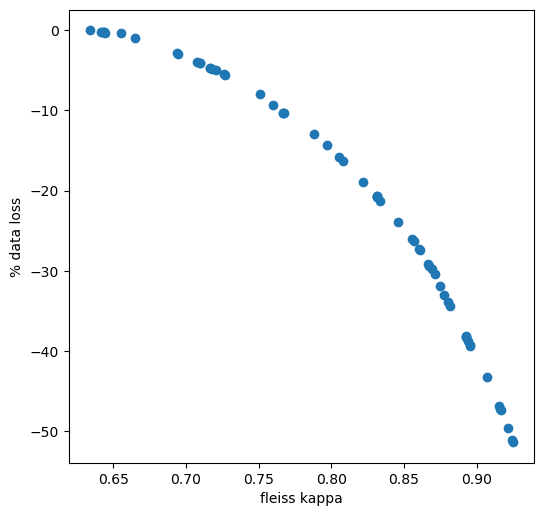

In [213]:
plt.figure(figsize=(6, 6), dpi=100)

plt.scatter(fk_scores, data_sizes)
plt.xlabel('fleiss kappa')
plt.ylabel('% data loss')

Получаем фронт паретто (если в данном случае такая формулировка подходит). Можем выбрать оптимальное соотношение между IAA и потерей данных. 

## EDA

In [12]:
data = data.reset_index(drop=True)
data

,text,extra_info,results,task_type,dataset_id,Null,task_id
0,Предпосылка: Девушка с зонтов шумит возле вход...,{'id': 0},"[{'user_id': 62296154, 'value': {'value': '169...",text,512.0,NaN,NaN
1,Предпосылка: Маленький мальчик катается на вел...,{'id': 1},"[{'user_id': 313883831, 'value': {'value': '16...",text,512.0,NaN,NaN
2,Предпосылка: Наука основана на эмпирических да...,{'id': 3},"[{'user_id': 142862059, 'value': {'value': '16...",text,512.0,NaN,18876.0
3,Предпосылка: Молодой человек в спортивной форм...,{'id': 4},"[{'user_id': 132477092, 'value': {'value': '16...",text,512.0,NaN,18876.0
4,Предпосылка: Мужчина сидит на диване смотря на...,{'id': 5},"[{'user_id': 132954861, 'value': {'value': '16...",text,512.0,NaN,18876.0
...,...,...,...,...,...,...,...
70026,Предпосылка: Генетически измененные овощи — эт...,{'id': 27},"[{'user_id': 94054619, 'value': {'value': '172...",NaN,NaN,NaN,NaN
70027,Предпосылка: Женщина катается на велосипеде с ...,{'id': 28},"[{'user_id': 184264174, 'value': {'value': '17...",NaN,NaN,NaN,NaN
70028,Предпосылка: Молодой человек находится на пляж...,{'id': 29},"[{'user_id': 94054619, 'value': {'value': '172...",NaN,NaN,NaN,NaN
70029,Предпосылка: Команда друзей готовит пикник в л...,{'id': 30},"[{'user_id': 184264174, 'value': {'value': '17...",NaN,NaN,NaN,NaN


[ 3.  4.  5.  6.  7. -1.] [66033    80     5     1     1  3911]


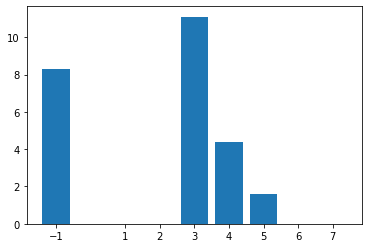

In [33]:
ann_per_samle = data['results'].apply(lambda x: annotations_count(x, np.sum))
values, counts = np.unique(ann_per_samle, return_counts=True)
values[-1] = -1
print(values, counts)
plt.bar(values, np.log(counts))
plt.xticks([-1, 1, 2, 3, 4, 5, 6, 7])
plt.show()
# ~6% плохой пример
# ~99% 3 аннотации на семпл

<BarContainer object of 3 artists>

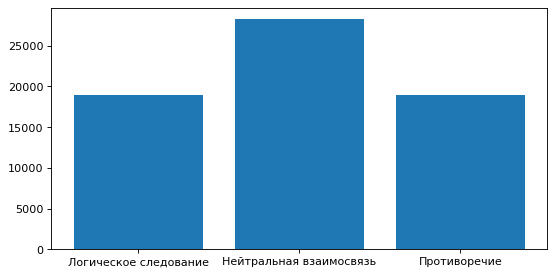

In [56]:
plt.figure(figsize=(8, 4), dpi=80)

# Посмотрим на распределение классов
ann_argmax = data['results'].apply(lambda x: annotations_count(x, f=np.argmax))
ann_argmax = ann_argmax.dropna()
values, ann_argmax = np.unique(ann_argmax, return_counts=True)
values = ['Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие']
plt.bar(values, ann_argmax)

# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

<BarContainer object of 3 artists>

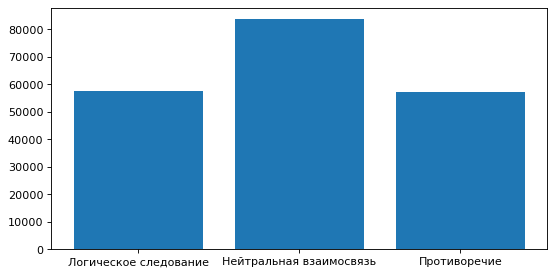

In [91]:
plt.figure(figsize=(8, 4), dpi=80)

# Посмотрим на распределение классов
ann_all = data['results'].apply(lambda x: annotations_count(x))
ann_all = ann_all.dropna()
ann_all = np.sum(list(ann_all), axis=0)

values = ['Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие']
plt.bar(values, ann_all)

# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

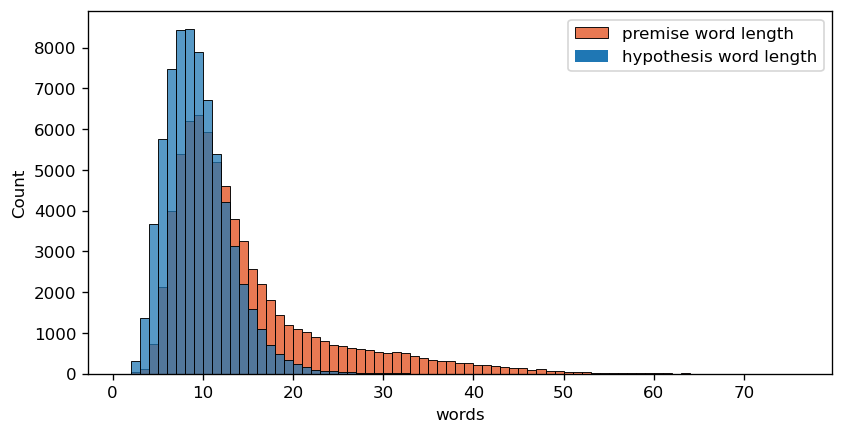

In [138]:
plt.figure(figsize=(8, 4), dpi=120)

def parse_text(text, f=None):
    premise, hypothethis = text.split(" Гипотеза: ")
    premise = premise.lstrip("Предпосылка: ")
    
    if f is not None:
        return f(premise, hypothethis)
    return premise, hypothethis

def premise_char_length(premise, hypothethis):
    return len(premise)

def premise_word_length(premise, hypothethis):
    return len(premise.split(' '))

def hypothethis_char_length(premise, hypothethis):
    return len(hypothethis)

def hypothethis_word_length(premise, hypothethis):
    return len(hypothethis.split(' '))


premise_wl = data['text'].apply(lambda text: parse_text(text, f=premise_word_length))
premise_wl = np.array(list(premise_wl))
sns.histplot(premise_wl, binwidth=1, color='#e24c1a')

hypothethis_wl = data['text'].apply(lambda text: parse_text(text, f=hypothethis_word_length))
hypothethis_wl = np.array(list(hypothethis_wl))
sns.histplot(hypothethis_wl, binwidth=1)

plt.xlabel('words')
plt.legend(labels=['premise word length', 'hypothesis word length'])

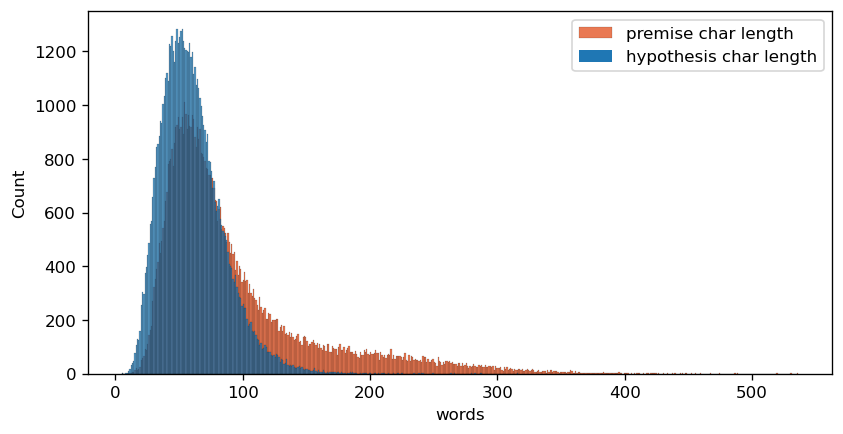

In [140]:
plt.figure(figsize=(8, 4), dpi=120)

premise_cl = data['text'].apply(lambda text: parse_text(text, f=premise_char_length))
premise_cl = np.array(list(premise_cl))
sns.histplot(premise_cl, binwidth=1, color='#e24c1a')

hypothethis_cl = data['text'].apply(lambda text: parse_text(text, f=hypothethis_char_length))
hypothethis_wl = np.array(list(hypothethis_cl))
sns.histplot(hypothethis_cl, binwidth=1)

plt.xlabel('words')
plt.legend(labels=['premise char length', 'hypothesis char length'])